# 🔬 DengAI Dengue Case Forecasting

1. Problem description & importance (4 pts)
2. Load data & split X/y (2 pts)
3. Preprocessing & feature engineering (5 pts) — time encoding, sequential missing value handling, lags/rolling, rainy season flag, high-correlation removal
4. EDA with Seaborn (4 pts)
5. Time-series cross-validation, MAE, model selection & tuning (7 pts)
6. Result analysis & conclusion (8 pts)

In [1]:
import warnings, os

warnings.filterwarnings("ignore")

from pathlib import Path
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

SEED = 11

np.random.seed(SEED)
DATA_DIR = Path("data")

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

In [2]:
X = pd.read_csv(DATA_DIR / "dengue_features_train.csv")
y = pd.read_csv(DATA_DIR / "dengue_labels_train.csv")

X_sj = X[X["city"] == "sj"]
X_iq = X[X["city"] == "iq"]

y_sj = y[y["city"] == "sj"]
y_iq = y[y["city"] == "iq"]

## Data splitting for train/test set

In [3]:
X_train_iq, y_train_iq = X_iq, y_iq
X_train_sj, y_train_sj = X_sj, y_sj
X_test = pd.read_csv(DATA_DIR / "dengue_features_test.csv")
X_test_sj = X_test[X_test["city"] == "sj"]
X_test_iq = X_test[X_test["city"] == "iq"]

## Data description

In [4]:
print("SJ Train:", X_train_sj.shape, " | SJ Test:", X_test_sj.shape)
print("IQ Train:", X_train_iq.shape, " | IQ Test:", X_test_iq.shape)

print("\nColumns in SJ:", X_train_sj.columns.tolist())
print("Columns in IQ:", X_train_iq.columns.tolist())

SJ Train: (936, 24)  | SJ Test: (260, 24)
IQ Train: (520, 24)  | IQ Test: (156, 24)

Columns in SJ: ['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']
Columns in IQ: ['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_s

In [5]:
print("Missing values in SJ:")
print(X_train_sj.isna().sum())

print()
print("\nDuplicates in SJ train:", X_train_sj.duplicated().sum())

Missing values in SJ:
city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c               

In [6]:
print("\nMissing values in IQ:")
print(X_train_iq.isna().sum())

print()
print("Duplicates in IQ train:", X_train_iq.duplicated().sum())


Missing values in IQ:
city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_m

In [7]:
print("SJ Train Description:")
display(X_train_sj.describe())

print("SJ Target:")
display(y_train_sj.describe())

SJ Train Description:


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,936.000000,936.000000,745.000000,887.000000,917.000000,917.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,1998.826923,26.503205,0.057925,0.067469,0.177655,0.165956,35.470809,299.163653,299.276920,295.109519,301.398817,297.301828,30.465419,78.568181,35.470809,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484
std,5.212076,15.021909,0.107153,0.092479,0.057166,0.056073,44.606137,1.236429,1.218637,1.569943,1.258927,1.294705,35.628055,3.389488,44.606137,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,297.800000,292.600000,0.000000,66.735714,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000
25%,1994.000000,13.750000,0.004500,0.016425,0.139283,0.129157,0.000000,298.195000,298.300000,293.847857,300.400000,296.300000,10.825000,76.246071,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000
50%,1999.000000,26.500000,0.057700,0.068075,0.177186,0.165971,20.800000,299.254286,299.378571,295.464286,301.500000,297.500000,21.300000,78.667857,20.800000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000
75%,2003.000000,39.250000,0.111100,0.115200,0.212557,0.202771,52.180000,300.132857,300.228571,296.418929,302.400000,298.400000,37.000000,80.963214,52.180000,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000
max,2008.000000,53.000000,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,304.300000,299.900000,570.500000,87.575714,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000


SJ Target:


,year,weekofyear,total_cases
count,936.000000,936.000000,936.000000
mean,1998.826923,26.503205,34.180556
std,5.212076,15.021909,51.381372
min,1990.000000,1.000000,0.000000
25%,1994.000000,13.750000,9.000000
50%,1999.000000,26.500000,19.000000
75%,2003.000000,39.250000,37.000000
max,2008.000000,53.000000,461.000000


In [8]:
print("IQ Train Description:")
display(X_train_iq.describe())

print("IQ Target:")
display(y_train_iq.describe())

IQ Train Description:


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,520.000000,520.000000,517.000000,517.000000,517.000000,517.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,483.000000,483.000000,506.000000,512.000000,504.000000
mean,2005.000000,26.503846,0.263869,0.238783,0.250126,0.266779,64.245736,297.869538,299.133043,295.492982,307.082752,292.866667,57.609864,88.639117,64.245736,17.096110,9.206783,27.530933,10.566197,34.004545,21.196680,62.467262
std,2.918283,15.029450,0.081370,0.076751,0.077354,0.086345,35.218995,1.170997,1.332073,1.417229,2.382980,1.663069,50.286555,7.583889,35.218995,1.445769,2.448525,0.921769,1.535496,1.325261,1.260327,63.245958
min,2000.000000,1.000000,0.061729,0.035860,0.029880,0.064183,0.000000,294.635714,294.892857,290.088571,300.000000,286.900000,0.000000,57.787143,0.000000,12.111429,3.714286,21.400000,5.200000,30.100000,14.700000,0.000000
25%,2002.750000,13.750000,0.200000,0.179540,0.194743,0.204129,39.105000,297.092500,298.221429,294.593929,305.200000,291.975000,24.065000,84.295000,39.105000,16.102857,7.371429,27.000000,9.500000,33.200000,20.600000,17.200000
50%,2005.000000,26.500000,0.263643,0.232971,0.249800,0.262143,60.470000,297.822857,299.121429,295.852143,307.050000,293.050000,46.440000,90.917143,60.470000,17.428571,8.964286,27.600000,10.625000,34.000000,21.300000,45.300000
75%,2007.250000,39.250000,0.319971,0.293929,0.302300,0.325150,85.757500,298.649286,300.123214,296.548571,308.700000,294.200000,71.072500,94.563929,85.757500,18.180357,11.014286,28.100000,11.655000,34.900000,22.000000,85.950000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,210.830000,301.637143,302.928571,298.450000,314.000000,296.000000,362.030000,98.610000,210.830000,20.461429,16.028571,30.800000,15.800000,42.200000,24.200000,543.300000


IQ Target:


,year,weekofyear,total_cases
count,520.000000,520.000000,520.000000
mean,2005.000000,26.503846,7.565385
std,2.918283,15.029450,10.765478
min,2000.000000,1.000000,0.000000
25%,2002.750000,13.750000,1.000000
50%,2005.000000,26.500000,5.000000
75%,2007.250000,39.250000,9.000000
max,2010.000000,53.000000,116.000000


In [9]:
print("SJ train years:", X_train_sj["year"].unique())
print("SJ test years:", X_test_sj["year"].unique())

print("IQ train years:", X_train_iq["year"].unique())
print("IQ test years:", X_test_iq["year"].unique())

SJ train years: [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008]
SJ test years: [2008 2009 2010 2011 2012 2013]
IQ train years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010]
IQ test years: [2010 2011 2012 2013]


## EDA - Visualization

In [10]:
def encode_time(df):
    df = df.copy()
    df["week_start_date"] = pd.to_datetime(df["week_start_date"])
    iso = df["week_start_date"].dt.isocalendar()
    df["cal_weekofyear"] = iso.week.astype(int)
    df["month"] = df["week_start_date"].dt.month.astype(int)
    df["quarter"] = df["week_start_date"].dt.quarter.astype(int)
    return df


X_train_iq = encode_time(X_train_iq)
X_train_sj = encode_time(X_train_sj)
X_test_iq = encode_time(X_test_iq)
X_test_sj = encode_time(X_test_sj)

# create df for visualization
df_sj = X_train_sj.copy()
df_iq = X_train_iq.copy()

df_sj["total_cases"] = y_train_sj["total_cases"]
df_iq["total_cases"] = y_train_iq["total_cases"]

In [11]:
def plot_time_series(df, city_name):
    plt.figure(figsize=(12, 4))
    plt.plot(df["week_start_date"], df["total_cases"], linewidth=1.5)
    plt.xlabel("Week Start Date")
    plt.ylabel("Number of Cases")
    plt.title(f"Dengue cases over time - {city_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_weekly_climatology(df, city_name):
    weekly = df.groupby("cal_weekofyear", as_index=False)["total_cases"].mean()
    plt.figure(figsize=(10, 4))
    plt.plot(weekly["cal_weekofyear"], weekly["total_cases"], marker="o", markersize=3)
    plt.xlabel("ISO Week")
    plt.ylabel("Average Number of Cases")
    plt.title(f"Weekly Climatology - {city_name}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(df, city_name, n_cols=40):
    num_cols = [
        c for c in df.columns if df[c].dtype.kind in "fc" and c != "total_cases"
    ]
    sample_cols = num_cols[:n_cols]
    corr = df[sample_cols + ["total_cases"]].corr(method="spearman")

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={"shrink": 0.8})
    plt.title(f"Correlation - {city_name}")
    plt.tight_layout()
    plt.show()


def plot_ts_decomposition(df, city_name, period=52):
    ts = df.set_index("week_start_date")["total_cases"]
    decomp = seasonal_decompose(ts, model="additive", period=period)

    fig, axes = plt.subplots(4, 1, figsize=(12, 10))

    ts.plot(ax=axes[0], title=f"{city_name} Original")
    decomp.trend.plot(ax=axes[1], title=f"{city_name} Trend")
    decomp.seasonal.plot(ax=axes[2], title=f"{city_name} Seasonal")
    decomp.resid.plot(ax=axes[3], title=f"{city_name} Residual")

    plt.tight_layout()
    plt.show()


def plot_distributions(df, city_name, bins=30, n_cols=4):
    exclude_cols = [
        "city",
        "year",
        "weekofyear",
        "week_start_date",
        "month",
        "quarter",
        "cal_weekofyear",
    ]
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [c for c in num_cols if c not in exclude_cols]

    n = len(features)
    n_rows = (n + n_cols - 1) // n_cols

    fig = plt.figure(figsize=(16, n_rows * 3))
    # fig.suptitle(f'Feature Distributions - {city_name}', y=0.98)

    df[features].hist(
        bins=bins, layout=(n_rows, n_cols), figsize=(16, n_rows * 3), grid=False
    )
    plt.tight_layout()
    plt.show()


def plot_all(df, city_name, n_cols=40):
    plot_time_series(df, city_name)
    plot_ts_decomposition(df, city_name)
    plot_weekly_climatology(df, city_name)
    plot_correlation_heatmap(df, city_name, n_cols)
    plot_distributions(df, city_name)

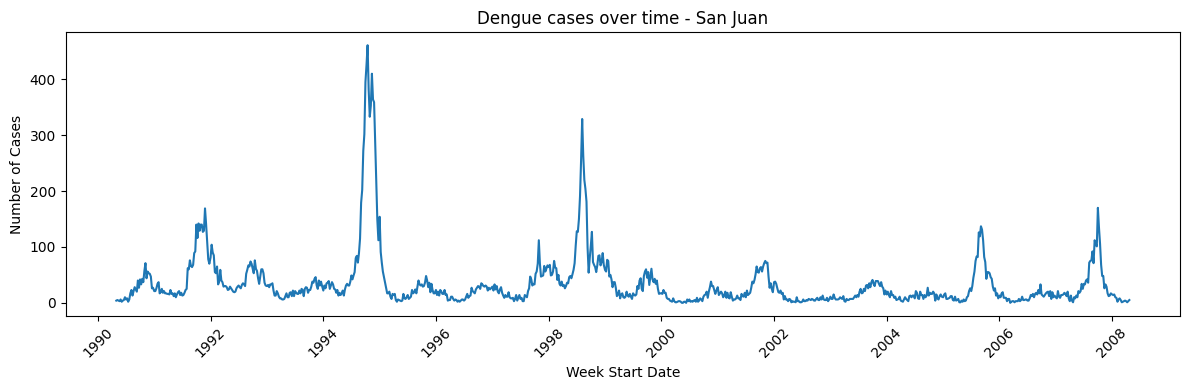

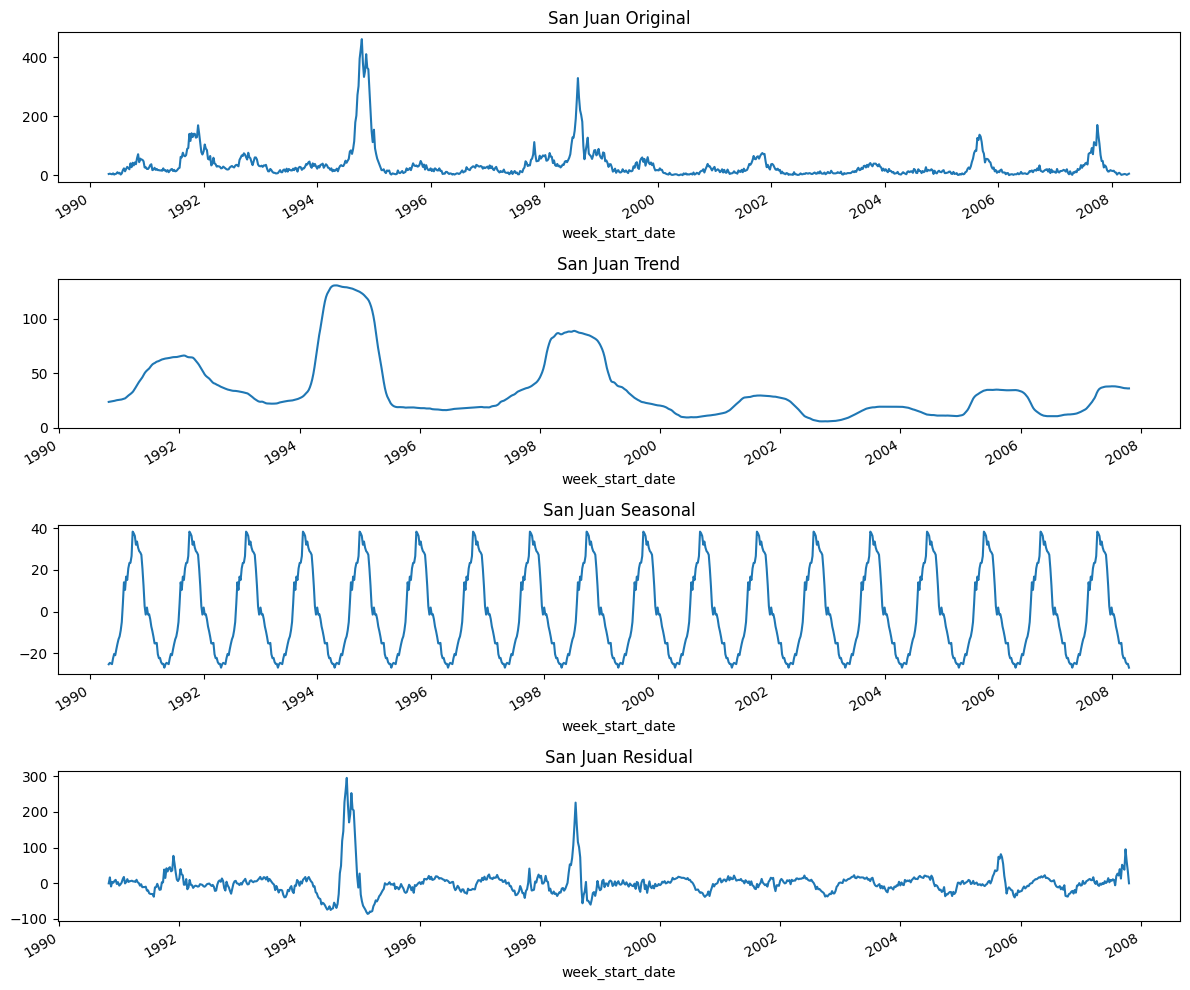

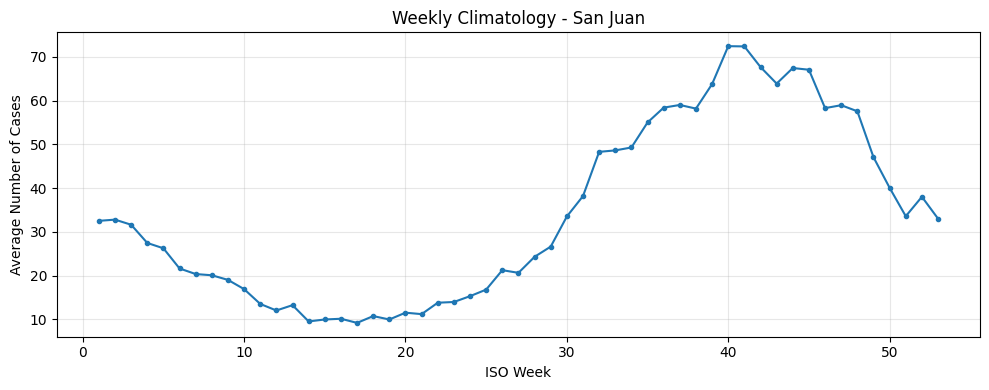

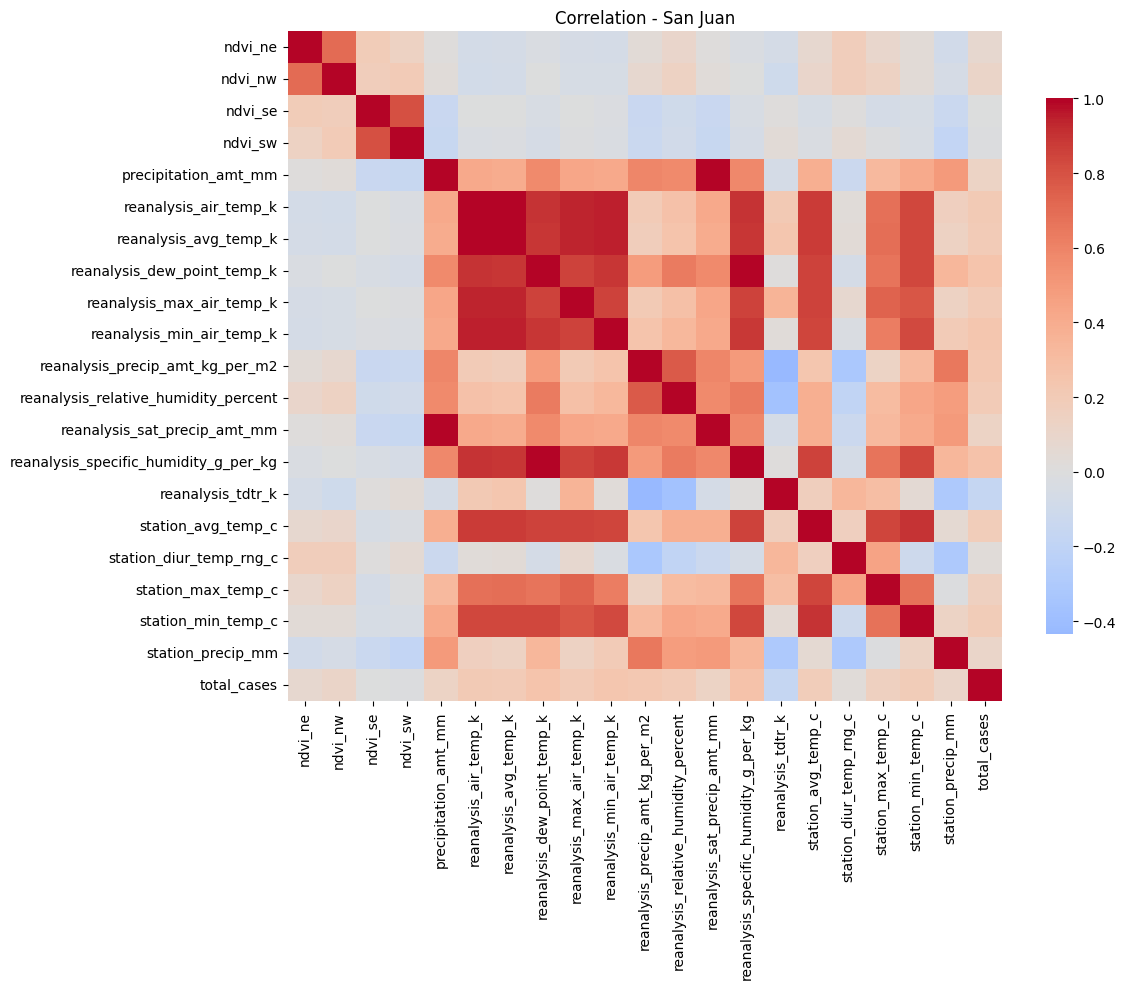

<Figure size 1600x1800 with 0 Axes>

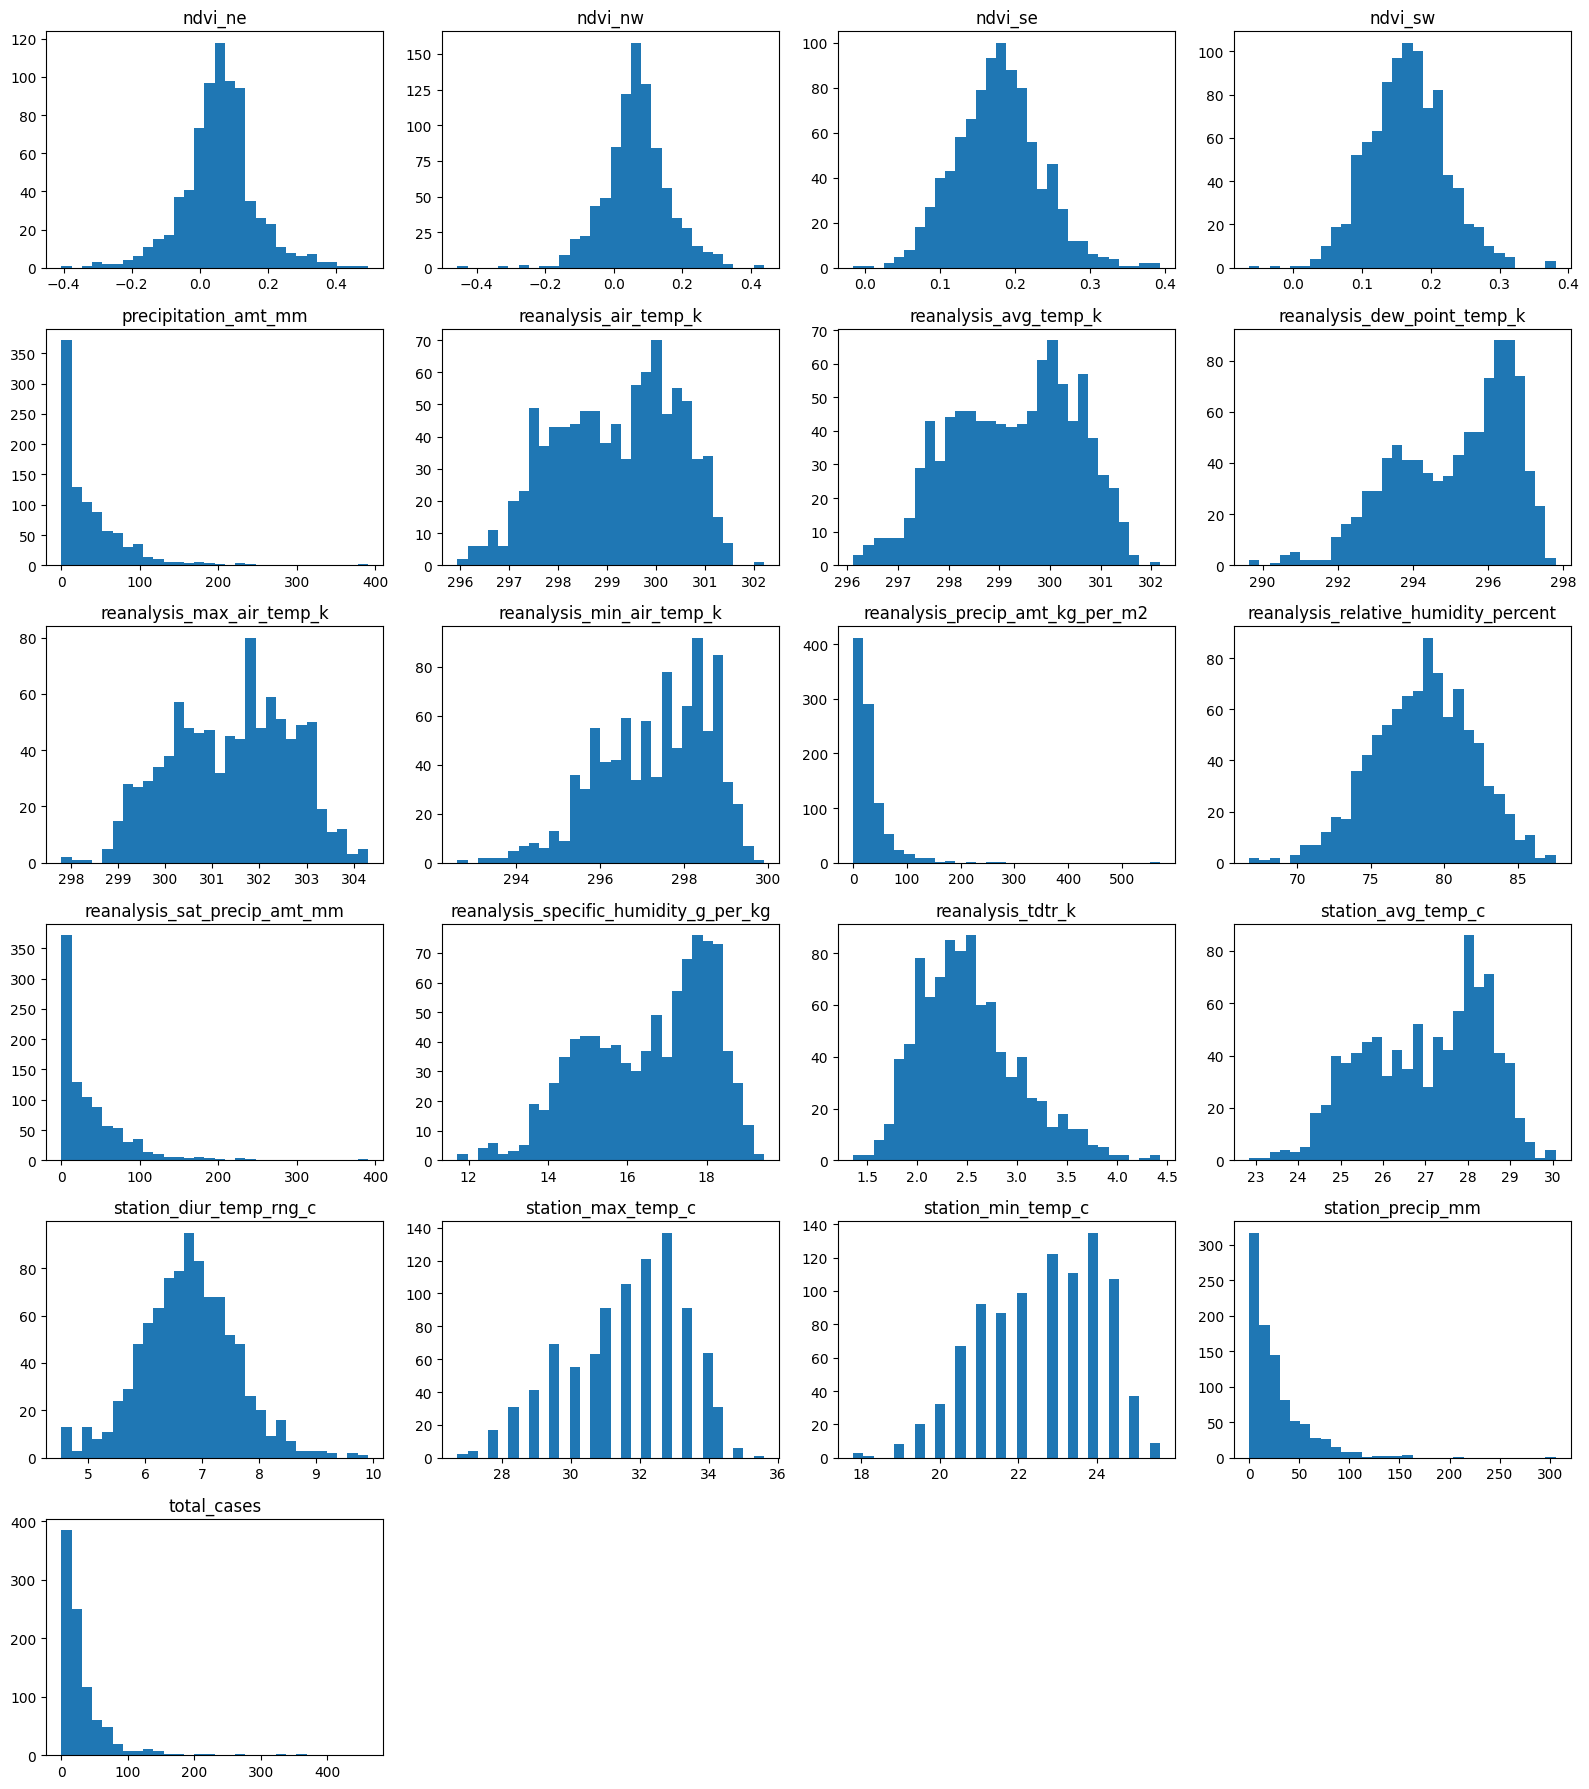

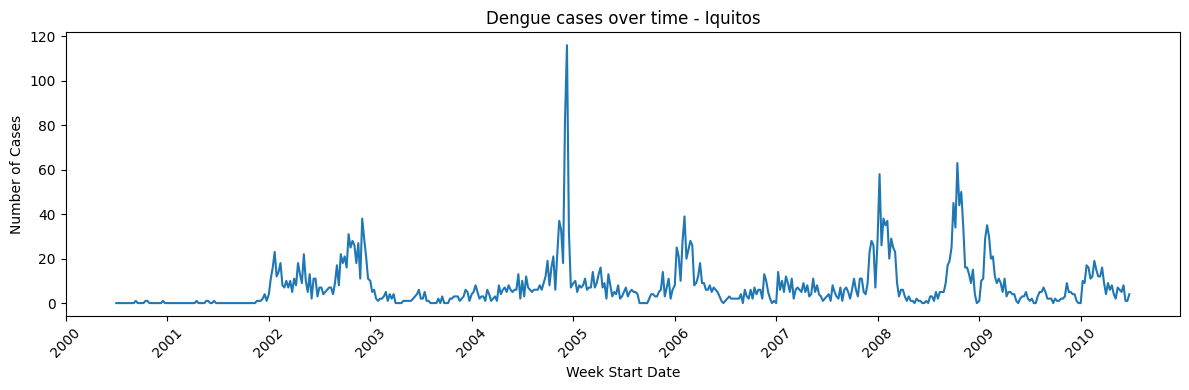

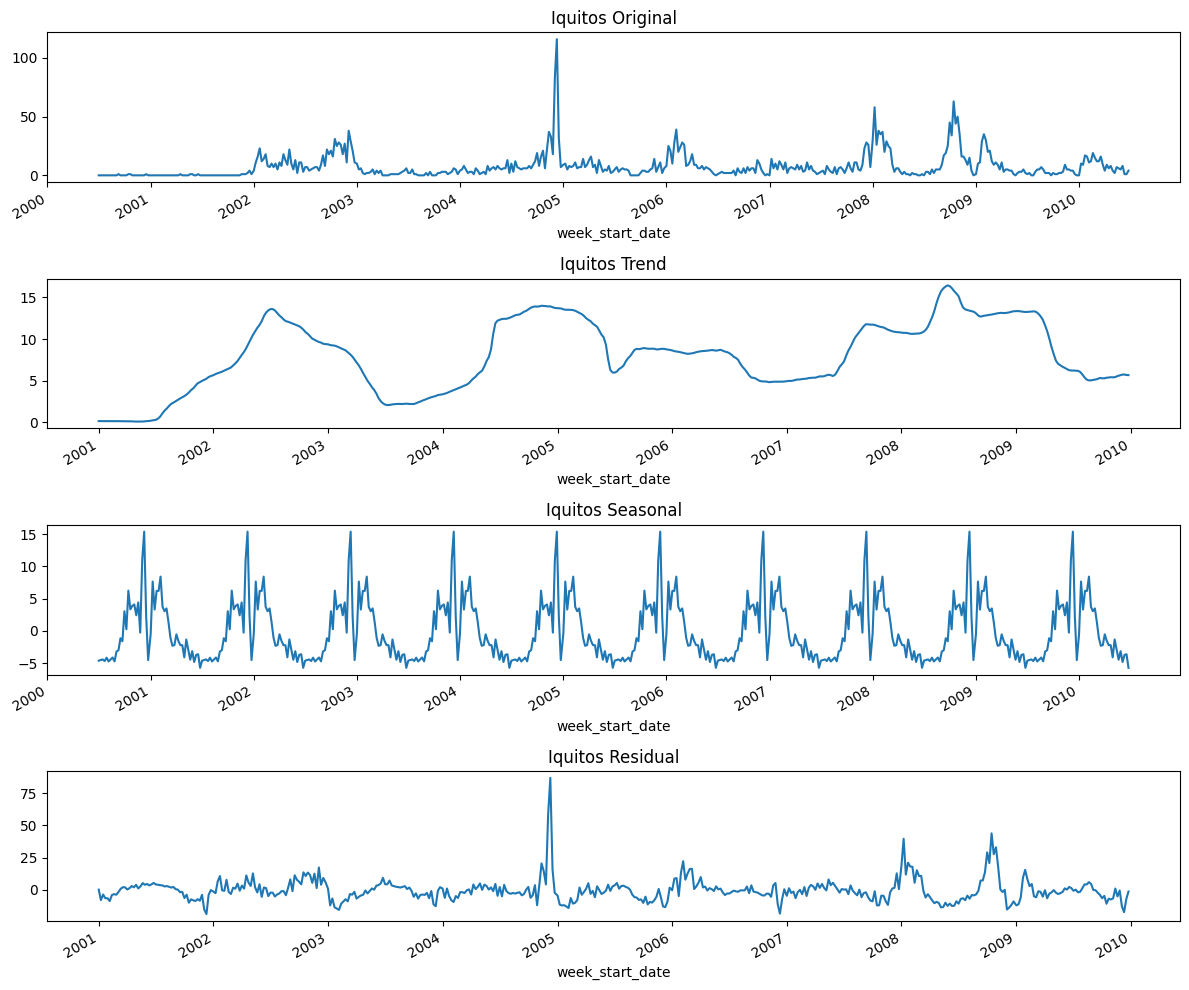

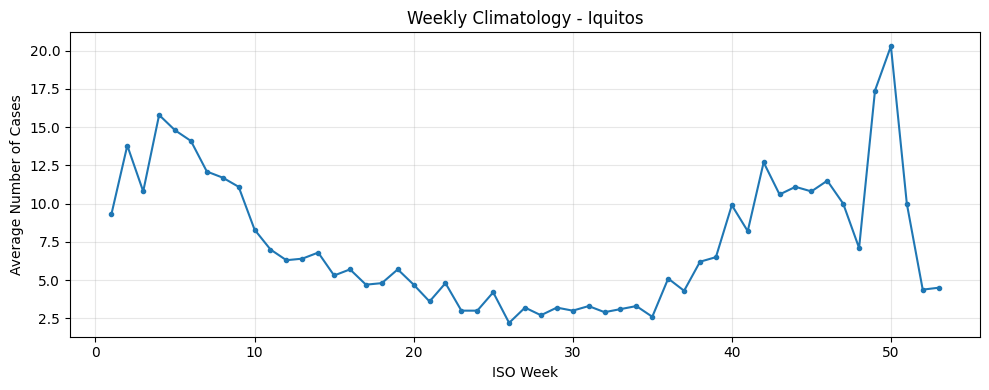

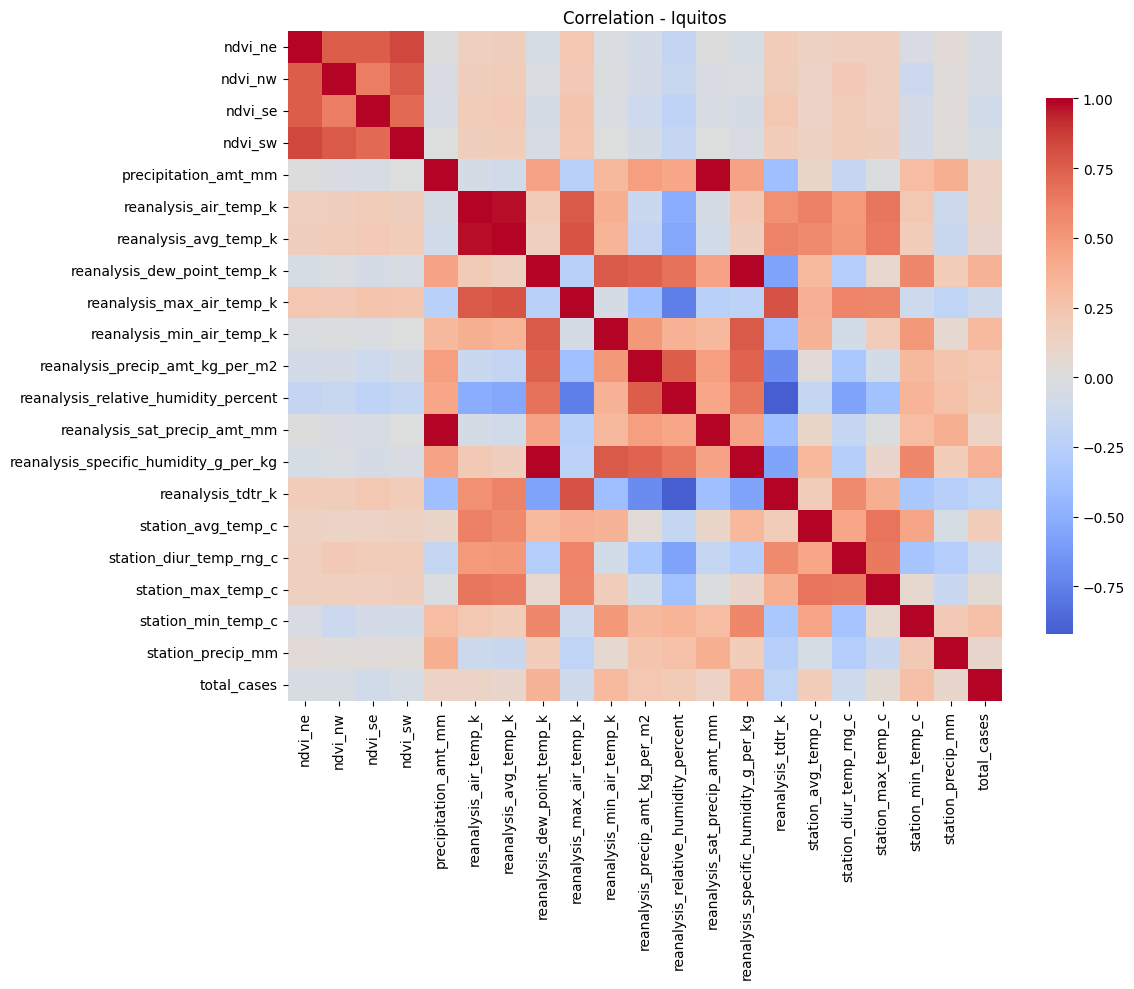

<Figure size 1600x1800 with 0 Axes>

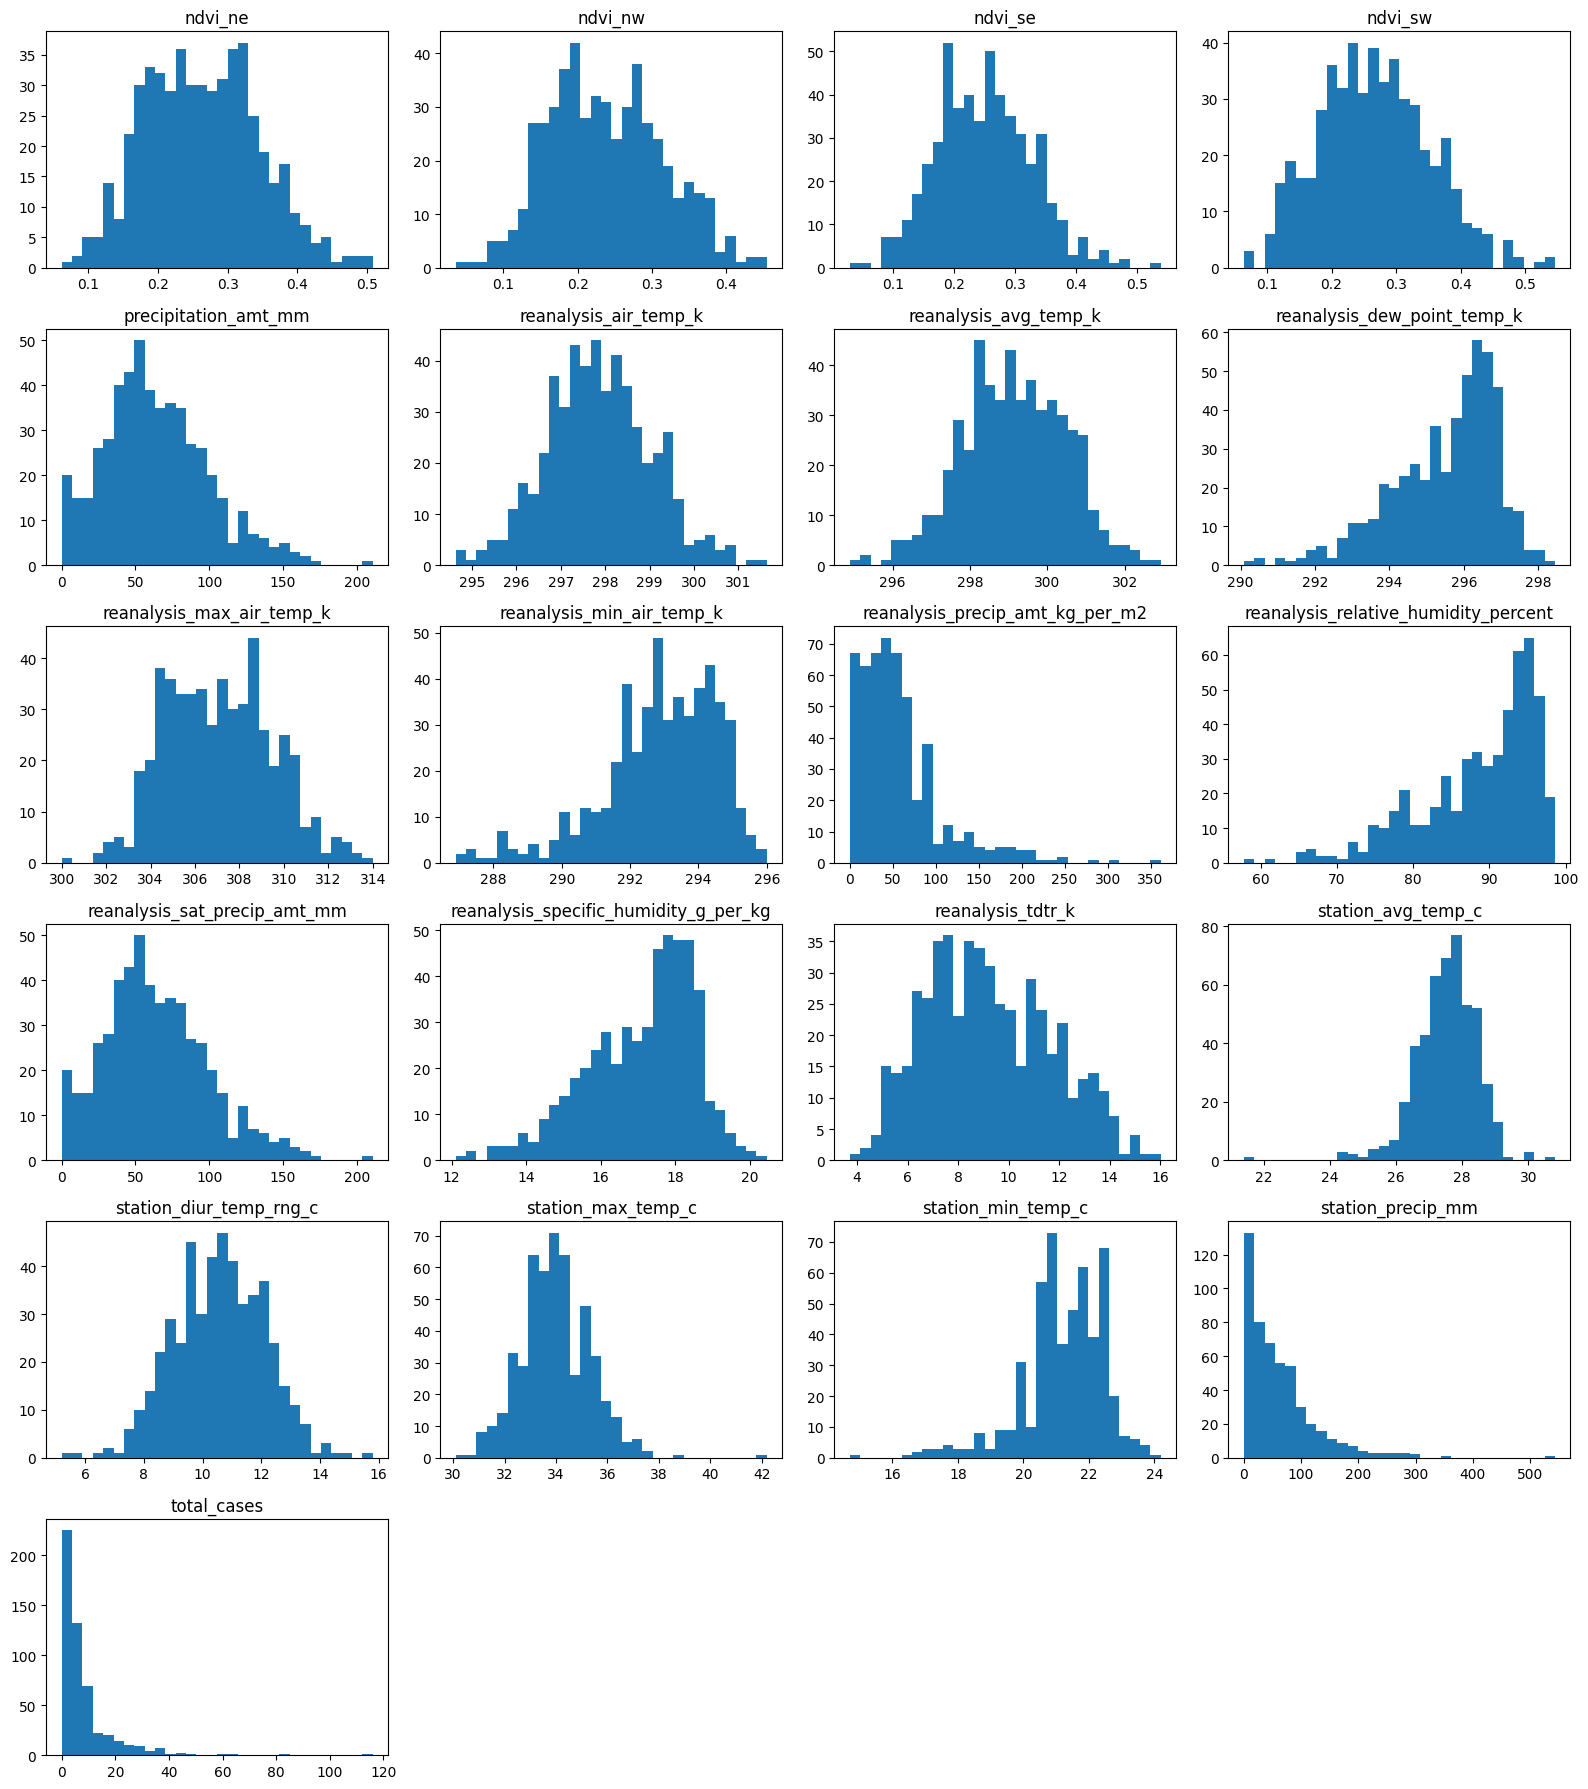

In [12]:
plot_all(df_sj, "San Juan")
plot_all(df_iq, "Iquitos")

## Feature engineering

In [13]:
LAGS = (1, 2, 3, 4, 8, 12)
ROLL_WINDOWS = (3, 8, 12)


def convert_kelvin(df):
    df = df.copy()
    k_cols = [c for c in df.columns if c.endswith("_k")]
    for col in k_cols:
        new_col = col.replace("_k", "_c")
        df[new_col] = df[col] - 273.15
    df.drop(columns=k_cols, inplace=True, errors="ignore")
    return df


def add_cyclical(df):
    df = df.copy()
    w = df["cal_weekofyear"].astype(float)
    df["week_sin"] = np.sin(2 * np.pi * w / 52.0)
    df["week_cos"] = np.cos(2 * np.pi * w / 52.0)
    return df


def fill_missing(df):
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].ffill()
    return df


def create_features(df):
    df = df.copy()
    exclude = [
        "city",
        "year",
        "weekofyear",
        "week_start_date",
        "total_cases",
        "cal_year",
        "cal_weekofyear",
        "month",
        "quarter",
        "week_sin",
        "week_cos",
    ]
    lag_cols = [c for c in df.columns if c not in exclude]
    precip_cols = [c for c in lag_cols if "precip" in c]

    for col in lag_cols:
        for L in LAGS:
            newc = f"{col}_lag{L}"
            df[newc] = df[col].shift(L)

    for col in lag_cols:
        if col in precip_cols:
            continue
        for W in ROLL_WINDOWS:
            newc = f"{col}_rollmean_{W}"
            df[newc] = df[col].shift(1).rolling(W, min_periods=1).mean()

    for col in precip_cols:
        for W in ROLL_WINDOWS:
            newc = f"{col}_rollsum_{W}"
            df[newc] = df[col].shift(1).rolling(W, min_periods=1).sum()

    return df


def add_wet_season(df, params=None):
    df = df.copy()
    wet_base = next(
        (
            c
            for c in [
                "reanalysis_precip_amt_kg_per_m2",
                "reanalysis_sat_precip_amt_mm",
                "precipitation_amt_mm",
                "station_precip_mm",
            ]
            if c in df.columns
        ),
        None,
    )

    if wet_base is None:
        df["wet_season"] = 0
        return (df, {"wet_base": None, "threshold": None}) if params is None else df

    roll4sum = df[wet_base].shift(1).rolling(4, min_periods=1).sum()

    if params is None:
        threshold = float(roll4sum.quantile(0.60))
        df["wet_season"] = (roll4sum > threshold).astype("int8")
        return df, {"wet_base": wet_base, "threshold": threshold}
    else:
        thr = params.get("threshold", np.nan)
        df["wet_season"] = (roll4sum > thr).astype("int8")
        return df


def drop_correlated(df, params=None, threshold=0.95):
    df = df.copy()
    exclude = ["city", "year", "weekofyear", "week_start_date", "total_cases"]

    if params is None:
        num_cols = [
            c for c in df.columns if c not in exclude and df[c].dtype.kind in "fc"
        ]
        if len(num_cols) < 2:
            return df, {"to_drop": []}
        corr = df[num_cols].corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        to_drop = [c for c in upper.columns if any(upper[c] > threshold)]
        df = df.drop(columns=to_drop, errors="ignore")
        return df, {"to_drop": to_drop}
    else:
        to_drop = [c for c in params.get("to_drop", []) if c in df.columns]
        df = df.drop(columns=to_drop, errors="ignore")
        return df


def transform_features(df, params=None):
    df = df.copy()
    df = convert_kelvin(df)
    df = add_cyclical(df)
    df = fill_missing(df)
    df = create_features(df)

    if params is None:
        df, wet_params = add_wet_season(df)
        df, corr_params = drop_correlated(df)
        return df, {"wet": wet_params, "corr": corr_params}
    else:
        df = add_wet_season(df, params["wet"])
        df = drop_correlated(df, params["corr"])
        return df


In [14]:
X_train_sj_feat, params_sj = transform_features(X_train_sj)
X_test_sj_feat = transform_features(X_test_sj, params=params_sj)
X_train_iq_feat, params_iq = transform_features(X_train_iq)
X_test_iq_feat = transform_features(X_test_iq, params=params_iq)

In [15]:
cols_to_drop = [
    "city",
    "week_start_date",
    "year",
    "weekofyear",
]

X_train_sj_feat = X_train_sj_feat.drop(columns=cols_to_drop, errors="ignore")
X_test_sj_feat = X_test_sj_feat.drop(columns=cols_to_drop, errors="ignore")
X_train_iq_feat = X_train_iq_feat.drop(columns=cols_to_drop, errors="ignore")
X_test_iq_feat = X_test_iq_feat.drop(columns=cols_to_drop, errors="ignore")

y_train_sj = y_train_sj.drop(columns=cols_to_drop, errors="ignore")
y_train_iq = y_train_iq.drop(columns=cols_to_drop, errors="ignore")

X_train_sj = X_train_sj.drop(columns=cols_to_drop, errors="ignore")
X_train_iq = X_train_iq.drop(columns=cols_to_drop, errors="ignore")
X_test_sj = X_test_sj.drop(columns=cols_to_drop, errors="ignore")
X_test_iq = X_test_iq.drop(columns=cols_to_drop, errors="ignore")

## Model training - Cross validation

In [16]:
BASE_PIPELINE = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
]

FEATURE_SELECTORS = {
    "SelectKBest": {
        "selector": SelectKBest(score_func=f_regression),
        "param_grid": {"selector__k": list(range(5, 46, 5))},
    },
    "RFE": {
        "selector": RFE(estimator=Ridge(random_state=SEED)),
        "param_grid": {"selector__n_features_to_select": list(range(5, 46, 5))},
    },
    "L1_Embedded": {
        "selector": SelectFromModel(Lasso(random_state=SEED)),
        "param_grid": {"selector__estimator__alpha": [0.001, 0.01, 0.1, 1.0]}
    },
    "RF_Embedded": {
        "selector": SelectFromModel(RandomForestRegressor(random_state=SEED, n_estimators=50)),
        "param_grid": {"selector__threshold": ["mean", "median"]}
    }
}

MODELS = {
    "Ridge": {
        "model": Ridge(random_state=SEED),
        "param_grid": {"model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]},
    },
    "KNN": {
        "model": KNeighborsRegressor(),
        "param_grid": {"model__n_neighbors": [3, 5, 7, 10, 15]}
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(random_state=SEED),
        "param_grid": {"model__max_depth": [3, 5, 10, 15]}
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=SEED, n_estimators=100),
        "param_grid": {"model__max_depth": [3, 5, 10], 'model__n_estimators': [50, 100, 200], 'model__min_samples_split': [2, 5, 10]}
    },
    "SVR": {
        "model": SVR(),
        "param_grid": {"model__C": [0.1, 1.0, 10.0], "model__epsilon": [0.01, 0.1, 1.0]}
    },
    "AdaBoost": {
        "model": AdaBoostRegressor(random_state=SEED),
        "param_grid": {"model__n_estimators": [50, 100, 200], "model__learning_rate": [0.5, 1.0, 1.5]}
    }
}


def run_experiments(X_train, y_train, X_test, city_name):
    results = []
    cv = TimeSeriesSplit(n_splits=4)

    print(city_name)
    total_combinations = len(FEATURE_SELECTORS) * len(MODELS)
    current = 0

    for fs_name, fs_config in FEATURE_SELECTORS.items():
        for model_name, model_config in MODELS.items():
            current += 1
            print(f"[{current}/{total_combinations}] {fs_name} + {model_name}")

            pipeline = Pipeline(
                BASE_PIPELINE
                + [("selector", fs_config["selector"])]
                + [("model", model_config["model"])]
            )

            param_grid = {**fs_config["param_grid"], **model_config["param_grid"]}

            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=cv,
                scoring="neg_mean_absolute_error",
                n_jobs=-1,
                refit=True,
            )

            grid_search.fit(X_train, y_train)

            cv_mae = -grid_search.best_score_
            y_test_pred = grid_search.best_estimator_.predict(X_test)
            # test_mae = mean_absolute_error(y_test, y_test_pred)

            results.append(
                {
                    "city": city_name,
                    "feature_selector": fs_name,
                    "model": model_name,
                    "best_params": grid_search.best_params_,
                    "cv_mae": cv_mae,
                    'best_estimator': grid_search.best_estimator_,
                }
            )

            print(f"  CV MAE: {cv_mae:.3f}")
    return results


def save_results(results, filename):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

In [17]:
results_sj = run_experiments(
    X_train_sj, y_train_sj, X_test_sj, "San Juan"
)
results_iq = run_experiments(
    X_train_iq, y_train_iq, X_test_iq, "Iquitos"
)

all_results = results_sj + results_iq
# save_results(all_results, "./results.csv")

San Juan
[1/24] SelectKBest + Ridge
  CV MAE: 31.896
[2/24] SelectKBest + KNN
  CV MAE: 30.167
[3/24] SelectKBest + DecisionTree
  CV MAE: 28.366
[4/24] SelectKBest + RandomForest
  CV MAE: 30.015
[5/24] SelectKBest + SVR
  CV MAE: 23.889
[6/24] SelectKBest + AdaBoost
  CV MAE: 37.115
[7/24] RFE + Ridge
  CV MAE: 31.102
[8/24] RFE + KNN
  CV MAE: 29.392
[9/24] RFE + DecisionTree
  CV MAE: 28.152
[10/24] RFE + RandomForest
  CV MAE: 29.653
[11/24] RFE + SVR
  CV MAE: 23.955
[12/24] RFE + AdaBoost
  CV MAE: 35.478
[13/24] L1_Embedded + Ridge
  CV MAE: 32.155
[14/24] L1_Embedded + KNN
  CV MAE: 32.061
[15/24] L1_Embedded + DecisionTree
  CV MAE: 29.961
[16/24] L1_Embedded + RandomForest
  CV MAE: 30.311
[17/24] L1_Embedded + SVR
  CV MAE: 24.553
[18/24] L1_Embedded + AdaBoost
  CV MAE: 36.122
[19/24] RF_Embedded + Ridge
  CV MAE: 32.275
[20/24] RF_Embedded + KNN
  CV MAE: 30.601
[21/24] RF_Embedded + DecisionTree
  CV MAE: 29.752
[22/24] RF_Embedded + RandomForest
  CV MAE: 29.430
[23/24]

In [18]:
results_df = pd.DataFrame(all_results)
best_results = results_df.loc[results_df.groupby(["city"])["cv_mae"].idxmin()]
display(best_results)

,city,feature_selector,model,best_params,cv_mae,best_estimator
30,Iquitos,RFE,Ridge,"{'model__alpha': 100.0, 'selector__n_features_...",6.363122,"(SimpleImputer(strategy='median'), StandardSca..."
4,San Juan,SelectKBest,SVR,"{'model__C': 1.0, 'model__epsilon': 1.0, 'sele...",23.889309,"(SimpleImputer(strategy='median'), StandardSca..."


In [19]:
sj_pred = best_results.loc[best_results["city"] == "San Juan", "best_estimator"].values[0].predict(X_test_sj)
iq_pred = best_results.loc[best_results["city"] == "Iquitos", "best_estimator"].values[0].predict(X_test_iq)

res = X_test[["city", "year", "weekofyear"]].copy()
res["total_cases"] = np.nan
res.loc[res["city"] == "sj", "total_cases"] = sj_pred
res.loc[res["city"] == "iq", "total_cases"] = iq_pred
res['total_cases'] = res['total_cases'].round().astype(int)

res.to_csv("submission.csv", index=False)